In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from fastai.vision import *
from modules.basics import *
from PIL import Image, ImageDraw, ImageFont
from concurrent.futures import ProcessPoolExecutor

In [2]:
IMG_PATH, DATA_PATH

(PosixPath('/home/giles/Documents/kaggle/higgsml'), PosixPath('../data'))

# Import data

Import and convert data

In [3]:
!python ../modules/data_import.py -d {DATA_PATH} -f PRI_jet_num -r True -z True -y True

Setting PRI_lep to phi = 0
Setting PRI_tau to positve phi
Setting PRI_lep to positive eta
eta component of PRI_met not found
Converting to use_cartesian coordinates
Setting PRI_lep to phi = 0
Setting PRI_tau to positve phi
Setting PRI_lep to positive eta
eta component of PRI_met not found
Converting to use_cartesian coordinates
Training on 200000 datapoints and validating on 50000, using 30 feats:
['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_met_px', 'PRI_met_py', 'PRI_met_pt']
Running train
Saving fold: 

Load processed data

In [4]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    feats = pickle.load(fin)
cont_feats = feats['cont_feats']
cat_feats = feats['cat_feats']    
cat_maps = feats['cat_maps']  
cat_szs = feats['cat_szs']  
train_feats = cont_feats + cat_feats

In [5]:
train_fy = FoldYielder(h5py.File(DATA_PATH/'train.hdf5', "r+"), cont_feats, cat_feats)
train_fy.add_input_pipe_from_file(DATA_PATH/'input_pipe.pkl')

In [6]:
df = train_fy.get_df(inc_inputs=True); len(df); df.head()

200000 candidates loaded


/home/giles/cernbox/lumin/lumin/nn/data/fold_yielder.py:115: UserWarning: pred not found in foldfile file
  warnings.warn(f'{pred_name} not found in foldfile file')


,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_lep_pz,PRI_jet_leading_px,PRI_jet_leading_py,PRI_jet_leading_pz,PRI_met_px,PRI_met_py,PRI_met_pt,PRI_jet_num,gen_target,gen_weight
0,0.000000,2.440682,0.042178,-0.608376,0.000000,0.000000,0.000000,0.660351,0.011274,-0.474278,...,0.245067,0.000000,0.000000,0.000000,-1.304366,0.451690,0.430630,0.0,0,0.000072
1,-0.463010,-0.809785,-0.459311,-0.431675,0.000000,0.000000,0.000000,0.685911,-0.543261,-0.557187,...,-0.285711,0.366393,0.204193,0.083714,0.223724,0.550056,-0.661287,1.0,0,0.000051
2,0.244210,-0.649494,0.546260,-0.837824,0.000000,0.000000,0.000000,0.903170,-0.639305,-0.611745,...,1.361912,0.000000,0.000000,0.000000,0.075411,-0.436091,-0.802279,0.0,1,0.000346
3,0.377215,-1.212751,0.204515,0.639349,2.351673,2.896331,-2.693055,0.605397,-0.739367,0.520510,...,0.158303,-0.498507,1.267615,3.700244,1.311881,-0.189099,0.630523,2.0,1,0.000028
4,-0.029281,-0.349494,0.099649,0.058481,0.000000,0.000000,0.000000,0.237335,-0.799663,-0.351442,...,-0.878904,0.178446,-0.355608,-0.370221,-0.101406,0.822616,-0.585792,1.0,0,0.000079


Convert inputs to lie between 0-255

In [7]:
def sigmoid(x:np.ndarray) -> np.ndarray: return 1/(1+np.exp(-x))

In [8]:
def convert_data(df:pd.DataFrame) -> None:
    x_cont = df[cont_feats].values
    df[cont_feats] = 255*sigmoid(x_cont)*(x_cont != 0)  # NB Boolean check to ensure missing values still have value of zero
    x_cat = df[cat_feats].values
    df[cat_feats] = 255*x_cat/np.max(x_cat, axis=0)
    df[train_feats] = np.round(df[train_feats].values).astype(np.uint8)

In [9]:
convert_data(df)

/home/giles/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


In [10]:
df.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_lep_pz,PRI_jet_leading_px,PRI_jet_leading_py,PRI_jet_leading_pz,PRI_met_px,PRI_met_py,PRI_met_pt,PRI_jet_num,gen_target,gen_weight
0,0,235,130,90,0,0,0,168,128,98,...,143,0,0,0,54,156,155,0,0,0.000072
1,98,79,99,100,0,0,0,170,94,93,...,109,151,140,133,142,162,87,85,0,0.000051
2,143,87,161,77,0,0,0,181,88,90,...,203,0,0,0,132,100,79,0,1,0.000346
3,151,58,140,167,233,242,16,165,82,160,...,138,96,199,249,201,115,166,170,1,0.000028
4,126,105,134,131,0,0,0,143,79,105,...,75,139,105,104,121,177,91,85,0,0.000079


/home/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


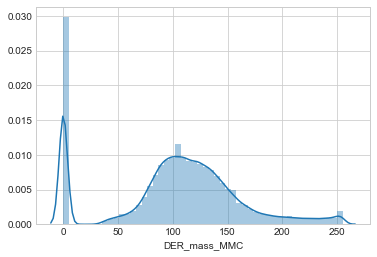

In [11]:
sns.distplot(df.DER_mass_MMC)

# Create images

In [24]:
def event2img(event:np.ndarray, size:int=224) -> PIL.Image.Image:
    arr = np.zeros([size,size], dtype=np.uint8)
    width, height = size//6, 6*size//(len(event)-1)
    for i, f in enumerate(event):
        arr[(i%6)*width:((i%6)+1)*width, (i//6)*height:((i+6)//6)*height] = f
    img = Image.fromarray(np.broadcast_to(arr[:,:,None], [size,size,3]), 'RGB')
    return img

CPU times: user 7.28 ms, sys: 0 ns, total: 7.28 ms
Wall time: 7.12 ms


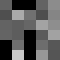

In [28]:
%%time
event2img(df[train_feats].values[1], 60)

In [35]:
for mode in ['train', 'val', 'test']:
    os.makedirs(IMG_PATH/'pixel_squares_images'/mode, exist_ok=True)

In [36]:
def save_image(event:np.ndarray, name:Union[str, int, float], loc:Path, size:int=224) -> None:
    img = event2img(event, size)
    name = str(name)
    if '.' not in name: name += '.png'
    img.save(loc/name)

In [37]:
def proc_sample(df:pd.DataFrame, mode:str, size:int=224) -> None:
    func = partial(save_image, loc=IMG_PATH/'pixel_squares_images'/mode, size=size)
    with ProcessPoolExecutor(10) as e: e.map(func, df[train_feats].values, df.index.values)

In [38]:
SIZE=224//4

In [39]:
%%time
train_fy = FoldYielder(h5py.File(DATA_PATH/'train.hdf5', "r+"), cont_feats, cat_feats)
train_fy.add_input_pipe_from_file(DATA_PATH/'input_pipe.pkl')
train_df = train_fy.get_df(inc_inputs=True)
convert_data(train_df)
proc_sample(train_df, 'train', SIZE)

/home/giles/cernbox/lumin/lumin/nn/data/fold_yielder.py:115: UserWarning: pred not found in foldfile file
  warnings.warn(f'{pred_name} not found in foldfile file')
/home/giles/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


200000 candidates loaded
CPU times: user 38.2 s, sys: 5.95 s, total: 44.2 s
Wall time: 40.8 s


In [40]:
train_df.reset_index(inplace=True)
train_df.rename(columns={'index':'image_name'}, inplace=True)
train_df.to_csv(IMG_PATH/'train.csv', index=False)

In [20]:
%%time
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"), cont_feats, cat_feats)
val_fy.add_input_pipe_from_file(DATA_PATH/'input_pipe.pkl')
val_df = val_fy.get_df(inc_inputs=True)
convert_data(val_df)
proc_sample(val_df, 'val', SIZE)

/home/giles/cernbox/lumin/lumin/nn/data/fold_yielder.py:115: UserWarning: pred not found in foldfile file
  warnings.warn(f'{pred_name} not found in foldfile file')


50000 candidates loaded
CPU times: user 8.76 s, sys: 1.53 s, total: 10.3 s
Wall time: 9.33 s


In [21]:
val_df.reset_index(inplace=True)
val_df.rename(columns={'index':'image_name'}, inplace=True)
val_df.to_csv(IMG_PATH/'val.csv', index=False)

In [22]:
%%time
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"), cont_feats, cat_feats)
test_fy.add_input_pipe_from_file(DATA_PATH/'input_pipe.pkl')
test_df = test_fy.get_df(inc_inputs=True)
test_df['private'] = test_fy.get_column('private')
convert_data(test_df)
proc_sample(test_df, 'test', SIZE)

/home/giles/cernbox/lumin/lumin/nn/data/fold_yielder.py:115: UserWarning: pred not found in foldfile file
  warnings.warn(f'{pred_name} not found in foldfile file')


550000 candidates loaded
CPU times: user 2min 6s, sys: 19.9 s, total: 2min 26s
Wall time: 2min 18s


In [23]:
test_df.reset_index(inplace=True)
test_df.rename(columns={'index':'image_name'}, inplace=True)
test_df.to_csv(IMG_PATH/'test.csv', index=False)